In [1]:
import os
import cv2
import numpy as np

def load_images_from_folder(base_path):
    data = []
    labels = []
    
    classes = sorted(os.listdir(base_path))  # Get class labels
    for class_index, class_name in enumerate(classes):
        class_folder = os.path.join(base_path, class_name)
        image_files = [os.path.join(class_folder, f) for f in os.listdir(class_folder) if f.endswith('.jpg')]

        for img_path in image_files:
            img = cv2.imread(img_path)  # Load image
            if img is None:
                continue  # Skip this image

            img = cv2.resize(img, (100, 100))  # Resize to 100x100
            img = img / 255.0  # Normalize to [0, 1]
            img = img.flatten()  # Flatten to 30,000 features
            
            data.append(img)
            labels.append(class_index)

    return np.array(data), np.array(labels)


In [2]:
# Load full dataset
train_data, train_labels = load_images_from_folder("../data/Q2/train")
test_data, test_labels = load_images_from_folder("../data/Q2/test")

libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile
libpng warning: iCCP: known incorrect sRGB profile


In [3]:
import numpy as np
from cvxopt import matrix, solvers
from itertools import combinations

class MultiClassSVM:
    def __init__(self, C=1.0, gamma=0.001):
        self.C = C
        self.gamma = gamma
        self.models = {}  # Dictionary to store binary classifiers
        self.classes = None

    def gaussian_kernel(self, X1, X2):
        """Compute the Gaussian (RBF) Kernel."""
        X1_norm = np.sum(X1**2, axis=1).reshape(-1, 1)
        X2_norm = np.sum(X2**2, axis=1).reshape(1, -1)
        distances = X1_norm + X2_norm - 2 * np.dot(X1, X2.T)
        return np.exp(-self.gamma * distances)

    def train_binary_svm(self, X, y):
        """Train a binary SVM using CVXOPT."""
        N = X.shape[0]
        y = y.astype(np.double).reshape(-1, 1)
        
        K = self.gaussian_kernel(X, X)

        P = matrix(np.outer(y, y) * K)
        q = matrix(-np.ones((N, 1)))
        G = matrix(np.vstack((-np.eye(N), np.eye(N))))
        h = matrix(np.hstack((np.zeros(N), np.ones(N) * self.C)))
        A = matrix(y.reshape(1, -1))
        b = matrix(0.0)

        solvers.options['show_progress'] = False
        solution = solvers.qp(P, q, G, h, A, b)
        alpha = np.ravel(solution['x'])

        sv = alpha > 1e-5  # Support vectors
        alpha_sv = alpha[sv]
        X_sv = X[sv]
        y_sv = y[sv]

        # Compute bias term (b)
        b = np.mean(y_sv - np.sum(alpha_sv * y_sv * K[sv][:, sv], axis=1))

        return alpha_sv, X_sv, y_sv, b

    def fit(self, X, y):
        """Train one binary SVM per class pair using One-vs-One (OvO) strategy."""
        self.classes = np.unique(y)
        self.models = {}

        for class_1, class_2 in combinations(self.classes, 2):
            mask = (y == class_1) | (y == class_2)
            X_binary, y_binary = X[mask], y[mask]
            y_binary = np.where(y_binary == class_1, 1, -1)

            alpha, X_sv, y_sv, b = self.train_binary_svm(X_binary, y_binary)

            self.models[(class_1, class_2)] = (alpha, X_sv, y_sv, b)

    def predict(self, X):
        """Predict using one-vs-one voting."""
        votes = np.zeros((X.shape[0], len(self.classes)))

        for (class_1, class_2), (alpha, X_sv, y_sv, b) in self.models.items():
            K = self.gaussian_kernel(X, X_sv)
            decision_values = np.sum(alpha * y_sv.T * K, axis=1) + b

            idx_1 = np.where(self.classes == class_1)[0][0]
            idx_2 = np.where(self.classes == class_2)[0][0]

            votes[:, idx_1] += (decision_values >= 0)
            votes[:, idx_2] += (decision_values < 0)

        return self.classes[np.argmax(votes, axis=1)]


In [4]:
# Instantiate and train the MultiClassSVM
svm_cvxopt = MultiClassSVM(C=1.0, gamma=0.01)
svm_cvxopt.fit(train_data, train_labels)

In [5]:
y_pred_cvxopt = svm_cvxopt.predict(test_data)

In [6]:
from sklearn.metrics import accuracy_score, classification_report

# Calculate accuracy
accuracy_svxopt = accuracy_score(test_labels, y_pred_cvxopt)
print(f"Accuracy: {accuracy_svxopt:.4f}")

# Display detailed classification report
print(classification_report(test_labels, y_pred_cvxopt))

Accuracy: 0.3362
              precision    recall  f1-score   support

           0       1.00      0.05      0.10       140
           1       0.91      0.61      0.73       171
           2       1.00      0.06      0.12        95
           3       1.00      0.26      0.41       128
           4       1.00      0.15      0.26       119
           5       1.00      0.09      0.17        76
           6       1.00      0.01      0.02       106
           7       1.00      0.06      0.12        47
           8       0.20      0.99      0.34       232
           9       0.98      0.32      0.48       139
          10       1.00      0.07      0.14       124

    accuracy                           0.34      1377
   macro avg       0.92      0.24      0.26      1377
weighted avg       0.85      0.34      0.30      1377



In [7]:
from sklearn.svm import SVC
import time

# Train One-vs-One Multi-Class SVM using Sklearn
start_time = time.time()

svm_sklearn = SVC(kernel="rbf", C=1.0, gamma=0.001, decision_function_shape='ovo')
svm_sklearn.fit(train_data, train_labels)

train_time_sklearn = time.time() - start_time

# Predict on test set
y_pred_sklearn = svm_sklearn.predict(test_data)

# Compute test accuracy
accuracy_sklearn = np.mean(y_pred_sklearn == test_labels)
print(f"Multi-Class SVM (Sklearn) Test Accuracy: {accuracy_sklearn:.4f}")
print(f"Training Time (Sklearn): {train_time_sklearn:.2f} seconds")


Multi-Class SVM (Sklearn) Test Accuracy: 0.6630
Training Time (Sklearn): 401.57 seconds


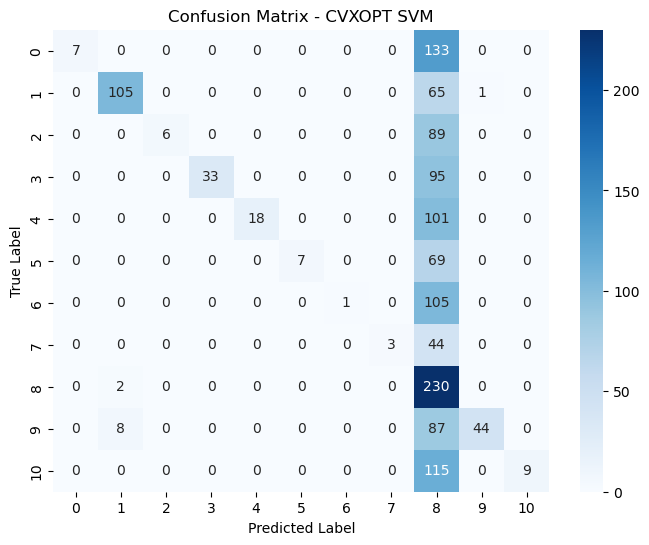

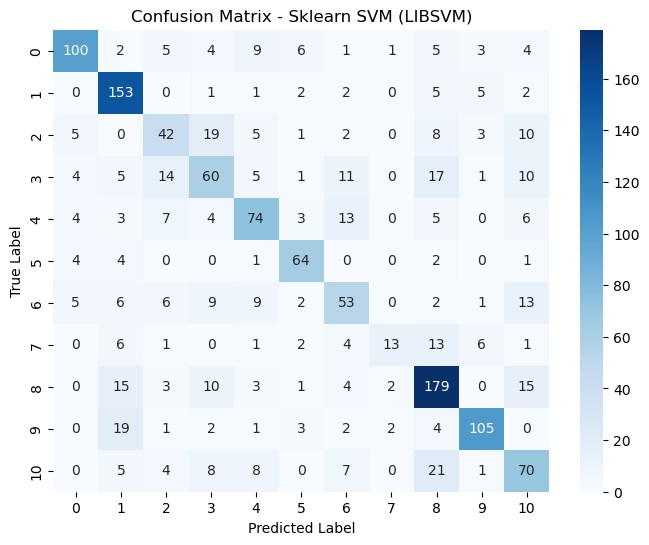

In [8]:
from sklearn.metrics import confusion_matrix
import seaborn as sns
import matplotlib.pyplot as plt
import numpy as np

# Define class labels from the unique test labels
class_labels = np.unique(test_labels)

# Compute confusion matrices
cm_cvxopt = confusion_matrix(test_labels, y_pred_cvxopt)
cm_sklearn = confusion_matrix(test_labels, y_pred_sklearn)

# Plot Confusion Matrices
def plot_confusion_matrix(cm, title):
    plt.figure(figsize=(8, 6))
    sns.heatmap(cm, annot=True, fmt="d", cmap="Blues", xticklabels=class_labels, yticklabels=class_labels)
    plt.xlabel("Predicted Label")
    plt.ylabel("True Label")
    plt.title(title)
    plt.show()

# Plot confusion matrices
plot_confusion_matrix(cm_cvxopt, "Confusion Matrix - CVXOPT SVM")
plot_confusion_matrix(cm_sklearn, "Confusion Matrix - Sklearn SVM (LIBSVM)")


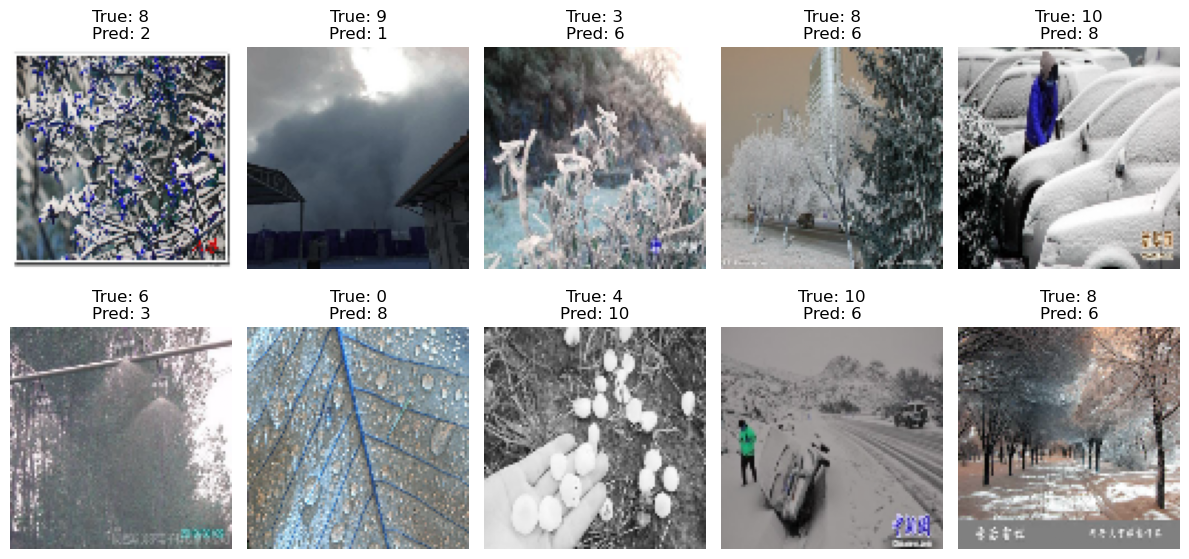

In [9]:
misclassified_indices = np.where(y_pred_sklearn != test_labels)[0]

# Select 10 random misclassified examples
num_examples = 10
random_indices = np.random.choice(misclassified_indices, num_examples, replace=False)

# Plot misclassified images
fig, axes = plt.subplots(2, 5, figsize=(12, 6))

for i, idx in enumerate(random_indices):
    ax = axes[i // 5, i % 5]
    img = test_data[idx].reshape(100, 100, 3)  # Reshape to image format
    ax.imshow(img)
    ax.set_title(f"True: {class_labels[test_labels[idx]]}\nPred: {class_labels[y_pred_sklearn[idx]]}")
    ax.axis("off")

plt.tight_layout()
plt.show()


In [1]:
from sklearn.svm import SVC
from sklearn.model_selection import cross_val_score
import numpy as np
import matplotlib.pyplot as plt

# Define the hyperparameter search space
C_values = [1e-5, 1e-3, 1, 5, 10]
gamma = 0.001

# Perform 5-fold cross-validation
cv_accuracies = []
test_accuracies = []

for C in C_values:
    # Create SVM model with RBF kernel
    svm = SVC(C=C, kernel='rbf', gamma=gamma)

    # Perform 5-fold cross-validation
    scores = cross_val_score(svm, train_data, train_labels, cv=5)
    avg_cv_accuracy = np.mean(scores)
    cv_accuracies.append(avg_cv_accuracy)

    # Train on full train data and test on test set
    svm.fit(train_data, train_labels)
    test_accuracy = svm.score(test_data, test_labels)
    test_accuracies.append(test_accuracy)

    print(f"C = {C}, Cross-validation Accuracy = {avg_cv_accuracy:.4f}, Test Accuracy = {test_accuracy:.4f}")

# Store best C based on cross-validation accuracy
best_C = C_values[np.argmax(cv_accuracies)]
print(f"\nBest C found: {best_C}")


C = 1e-05, Cross-validation Accuracy = 0.1693, Test Accuracy = 0.1685
C = 0.001, Cross-validation Accuracy = 0.1693, Test Accuracy = 0.1685
C = 1, Cross-validation Accuracy = 0.3245, Test Accuracy = 0.3250
C = 5, Cross-validation Accuracy = 0.3362, Test Accuracy = 0.3362
C = 10, Cross-validation Accuracy = 0.3367, Test Accuracy = 0.3375
